# Projet 9 : Réaliser une application de recommandation de contenu

Problématique : My Content est une start-up qui veut encourager la lecture en recommandant des contenus pertinents pour ses utilisateurs. Le but est de développer un MVP grâce à des données en ligne. Le modèle devra renvoyer une sélection de cinq articles.

L'application devra avoir une architecture serverless : API + Azure Fonction / Azure fonction

## Import des bibliothèques

In [13]:
import pandas as pd

In [14]:
import sys
# Insert the path of modules folder
sys.path.insert(0, "Package")

# Import the module0 directly since
# the current path is of modules.
import Scripts_Analyse01 as pk
import Scripts_AnalyseMulti01 as pk_multi
import Scripts_AnalyseMulti02_Unsupervised as pk_multi_unsp
import Scripts_AnalyseMulti02_Supervised as pk_multi_sup

D:\ProgramFiles\Anaconda3\envs\venv_009_2\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used


## Import des données

In [15]:
articles = pd.read_csv("Input\\articles_metadata.csv")

In [16]:
articles

article_id  category_id  created_at_ts  publisher_id  words_count
0                0            0  1513144419000             0          168
1                1            1  1405341936000             0          189
2                2            1  1408667706000             0          250
3                3            1  1408468313000             0          230
4                4            1  1407071171000             0          162
...            ...          ...            ...           ...          ...
364042      364042          460  1434034118000             0          144
364043      364043          460  1434148472000             0          463
364044      364044          460  1457974279000             0          177
364045      364045          460  1515964737000             0          126
364046      364046          460  1505811330000             0          479

[364047 rows x 5 columns]

In [17]:
articles.duplicated().sum()

0

In [18]:
articles.duplicated(["article_id", "category_id"]).sum()

0

In [19]:
from pathlib import Path
import pandas as pd
import numpy as np

path = r'Input\\clicks\\clicks'  # or unix / linux / mac path

# get the files from the path provided in the OP
files = Path(path).glob('*.csv')  # .rglob to get subdirectories

In [20]:
dfs = list()
for f in files:
    print(f)
    data = pd.read_csv(f)
        ## .stem is method for pathlib objects to get the filename w/o the extension
    data['file'] = f
    if 'df' in locals():
        df = pd.concat([df , data], ignore_index=True)
    else:
        df=data

Input\clicks\clicks\clicks_hour_000.csv
Input\clicks\clicks\clicks_hour_001.csv
Input\clicks\clicks\clicks_hour_002.csv
Input\clicks\clicks\clicks_hour_003.csv
Input\clicks\clicks\clicks_hour_004.csv
Input\clicks\clicks\clicks_hour_005.csv
Input\clicks\clicks\clicks_hour_006.csv
Input\clicks\clicks\clicks_hour_007.csv
Input\clicks\clicks\clicks_hour_008.csv
Input\clicks\clicks\clicks_hour_009.csv
Input\clicks\clicks\clicks_hour_010.csv
Input\clicks\clicks\clicks_hour_011.csv
Input\clicks\clicks\clicks_hour_012.csv
Input\clicks\clicks\clicks_hour_013.csv
Input\clicks\clicks\clicks_hour_014.csv
Input\clicks\clicks\clicks_hour_015.csv
Input\clicks\clicks\clicks_hour_016.csv
Input\clicks\clicks\clicks_hour_017.csv
Input\clicks\clicks\clicks_hour_018.csv
Input\clicks\clicks\clicks_hour_019.csv
Input\clicks\clicks\clicks_hour_020.csv
Input\clicks\clicks\clicks_hour_021.csv
Input\clicks\clicks\clicks_hour_022.csv
Input\clicks\clicks\clicks_hour_023.csv
Input\clicks\clicks\clicks_hour_024.csv


In [21]:
df.head(2)

user_id        session_id  session_start session_size click_article_id  \
0       0  1506825423271737  1506825423000            2           157541   
1       0  1506825423271737  1506825423000            2            68866   

  click_timestamp click_environment click_deviceGroup click_os click_country  \
0   1506826828020                 4                 3       20             1   
1   1506826858020                 4                 3       20             1   

  click_region click_referrer_type                                     file  
0           20                   2  Input\clicks\clicks\clicks_hour_000.csv  
1           20                   2  Input\clicks\clicks\clicks_hour_000.csv

In [22]:
df.duplicated().sum()

0

In [23]:
df.duplicated(["user_id", "session_id", "click_article_id", "click_timestamp"]).sum()

0

Nous avons aucun doublon.

In [24]:
art_embed = pd.read_pickle('Input\\articles_embeddings.pickle')
art_embed.shape

(364047, 250)

In [25]:
art_embed

array([[-0.16118301, -0.95723313, -0.13794445, ..., -0.231686  ,
         0.5974159 ,  0.40962312],
       [-0.52321565, -0.974058  ,  0.73860806, ...,  0.18282819,
         0.39708954, -0.83436364],
       [-0.61961854, -0.9729604 , -0.20736018, ..., -0.44758022,
         0.8059317 , -0.28528407],
       ...,
       [-0.25139043, -0.9762427 ,  0.58609664, ..., -0.14372464,
         0.06809307, -0.7050104 ],
       [ 0.22434181, -0.92328775, -0.38174152, ...,  0.6871319 ,
        -0.5315117 ,  0.01072566],
       [-0.25713393, -0.9946313 ,  0.9837918 , ...,  0.98387307,
        -0.8381829 , -0.1792827 ]], dtype=float32)

In [26]:
articles.shape

(364047, 5)

## Construction de la base de données

Fusionnons nos deux tables.

In [ ]:
df

user_id        session_id  session_start session_size  \
0             0  1506825423271737  1506825423000            2   
1             0  1506825423271737  1506825423000            2   
2             1  1506825426267738  1506825426000            2   
3             1  1506825426267738  1506825426000            2   
4             2  1506825435299739  1506825435000            2   
...         ...               ...            ...          ...   
2988176   10051  1508211372158328  1508211372000            2   
2988177  322896  1508211376302329  1508211376000            2   
2988178  322896  1508211376302329  1508211376000            2   
2988179  123718  1508211379189330  1508211379000            2   
2988180  123718  1508211379189330  1508211379000            2   

        click_article_id click_timestamp click_environment click_deviceGroup  \
0                 157541   1506826828020                 4                 3   
1                  68866   1506826858020                 4                 3   
2                 235840   1506827017951                 4                 1   
3                  96663   1506827047951                 4                 1   
4                 119592   1506827090575                 4                 1   
...                  ...             ...               ...               ...   
2988176            84911   1508211557302                 4                 3   
2988177            30760   1508211672520                 4                 1   
2988178           157507   1508211702520                 4                 1   
2988179           234481   1508211513583                 4                 3   
2988180           233578   1508211543583                 4                 3   

        click_os click_country click_region click_referrer_type  \
0             20             1           20                   2   
1             20             1           20                   2   
2             17             1           16                   2   
3             17             1           16                   2   
4             17             1           24                   2   
...          ...           ...          ...                 ...   
2988176        2             1           25                   1   
2988177       17             1           25                   2   
2988178       17             1           25                   2   
2988179        2             1           25                   2   
2988180        2             1           25                   2   

                                            file  
0        Input\clicks\clicks\clicks_hour_000.csv  
1        Input\clicks\clicks\clicks_hour_000.csv  
2        Input\clicks\clicks\clicks_hour_000.csv  
3        Input\clicks\clicks\clicks_hour_000.csv  
4        Input\clicks\clicks\clicks_hour_000.csv  
...                                          ...  
2988176  Input\clicks\clicks\clicks_hour_384.csv  
2988177  Input\clicks\clicks\clicks_hour_384.csv  
2988178  Input\clicks\clicks\clicks_hour_384.csv  
2988179  Input\clicks\clicks\clicks_hour_384.csv  
2988180  Input\clicks\clicks\clicks_hour_384.csv  

[2988181 rows x 13 columns]

In [27]:
articles.columns = ["click_article_id", "category_id", "created_at_ts", "publisher_id", "words_count"]

In [28]:
articles

click_article_id  category_id  created_at_ts  publisher_id  \
0                      0            0  1513144419000             0   
1                      1            1  1405341936000             0   
2                      2            1  1408667706000             0   
3                      3            1  1408468313000             0   
4                      4            1  1407071171000             0   
...                  ...          ...            ...           ...   
364042            364042          460  1434034118000             0   
364043            364043          460  1434148472000             0   
364044            364044          460  1457974279000             0   
364045            364045          460  1515964737000             0   
364046            364046          460  1505811330000             0   

        words_count  
0               168  
1               189  
2               250  
3               230  
4               162  
...             ...  
364042          144  
364043          463  
364044          177  
364045          126  
364046          479  

[364047 rows x 5 columns]

In [29]:
for idx, rows in articles.iterrows():
    print()

In [30]:
dfs = df.join(articles, how='left', on='click_article_id', lsuffix="_1")

In [31]:
del dfs["click_article_id_1"]

In [32]:
max(dfs["click_article_id"])

364046

In [33]:
max(articles["click_article_id"])

364046

In [34]:
dfs_agg_4 = dfs.groupby(["user_id", "click_article_id"])["click_article_id"].count().reset_index(name="nb_click_by_arts")

Vérification des données manquantes

In [35]:
tab = pk.del_Nan(dfs, 0.0000000001, 0, 0)

In [ ]:
tab

Empty DataFrame
Columns: [index, freq]
Index: []

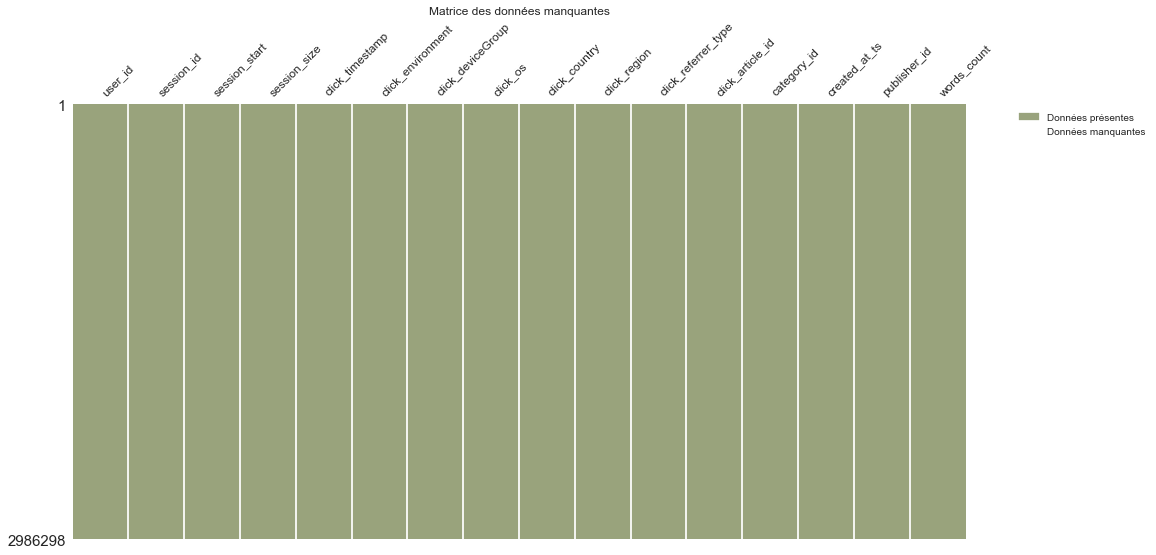

In [ ]:
pk.matrix_vm(dfs, (16, 8), (0.60, 0.64, 0.49))

Aucune donnée manquante

Création indicateurs

In [ ]:
articles

article_id  category_id  created_at_ts  words_count
0                0            0  1513144419000          168
1                1            1  1405341936000          189
2                2            1  1408667706000          250
3                3            1  1408468313000          230
4                4            1  1407071171000          162
...            ...          ...            ...          ...
364042      364042          460  1434034118000          144
364043      364043          460  1434148472000          463
364044      364044          460  1457974279000          177
364045      364045          460  1515964737000          126
364046      364046          460  1505811330000          479

[364047 rows x 4 columns]

In [36]:
dfs_agg = pd.DataFrame( dfs.groupby(['user_id'])['click_article_id'].count().reset_index(name="total_click"))


In [37]:
dfs_agg

user_id  total_click
0             0            8
1             1           12
2             2            4
3             3           17
4             4            7
...         ...          ...
322892   322892            2
322893   322893            2
322894   322894            2
322895   322895            2
322896   322896            2

[322897 rows x 2 columns]

In [38]:
dfs_agg_2 = pd.DataFrame(dfs.groupby(['user_id','category_id' ])['click_article_id'].count().reset_index(name="total_click_by_cat"))


In [39]:
dfs_agg_2

user_id  category_id  total_click_by_cat
0              0          136                   1
1              0          186                   2
2              0          209                   1
3              0          281                   2
4              0          375                   1
...          ...          ...                 ...
1882297   322894          297                   1
1882298   322895          133                   1
1882299   322895          418                   1
1882300   322896           26                   1
1882301   322896          281                   1

[1882302 rows x 3 columns]

In [40]:
dfs_agg_2.loc[dfs_agg_2["user_id"]==0]

user_id  category_id  total_click_by_cat
0        0          136                   1
1        0          186                   2
2        0          209                   1
3        0          281                   2
4        0          375                   1
5        0          431                   1

In [41]:
dfs_agg_3 = dfs_agg_2.join(dfs_agg, how='left', on='user_id', lsuffix="_1")

In [42]:
dfs_agg_3.loc[dfs_agg_3["user_id"]==0]

user_id_1  category_id  total_click_by_cat  user_id  total_click
0          0          136                   1        0            8
1          0          186                   2        0            8
2          0          209                   1        0            8
3          0          281                   2        0            8
4          0          375                   1        0            8
5          0          431                   1        0            8

In [43]:
del dfs_agg_3["user_id_1"]

In [44]:
dfs_agg = dfs_agg_3.copy()

In [45]:
dfs_agg

category_id  total_click_by_cat  user_id  total_click
0                136                   1        0            8
1                186                   2        0            8
2                209                   1        0            8
3                281                   2        0            8
4                375                   1        0            8
...              ...                 ...      ...          ...
1882297          297                   1   322894            2
1882298          133                   1   322895            2
1882299          418                   1   322895            2
1882300           26                   1   322896            2
1882301          281                   1   322896            2

[1882302 rows x 4 columns]

Créons un taux en fonction du nombre de clicks

In [46]:
dfs_agg['rating'] = dfs_agg['total_click_by_cat'] / dfs_agg['total_click']


In [47]:
dfs_agg.loc[dfs_agg["user_id"]==0]

category_id  total_click_by_cat  user_id  total_click  rating
0          136                   1        0            8   0.125
1          186                   2        0            8   0.250
2          209                   1        0            8   0.125
3          281                   2        0            8   0.250
4          375                   1        0            8   0.125
5          431                   1        0            8   0.125

## Exploration des données

### Statistiques descriptives

In [ ]:
dfs_agg["category_id"].nunique()

316

In [ ]:
dfs_agg["user_id"].nunique()

322897

In [ ]:
dfs_agg.describe()

category_id  total_click_by_cat       user_id   total_click  \
count  1.882302e+06        1.882302e+06  1.882302e+06  1.882302e+06   
mean   3.016577e+02        1.587514e+00  1.205252e+05  2.289332e+01   
std    1.191309e+02        1.921600e+00  8.726865e+04  3.391055e+01   
min    1.000000e+00        1.000000e+00  0.000000e+00  2.000000e+00   
25%    2.470000e+02        1.000000e+00  4.710600e+04  6.000000e+00   
50%    3.270000e+02        1.000000e+00  1.037510e+05  1.300000e+01   
75%    4.090000e+02        2.000000e+00  1.837410e+05  2.800000e+01   
max    4.600000e+02        5.350000e+02  3.228960e+05  1.232000e+03   

             rating  
count  1.882302e+06  
mean   1.715437e-01  
std    1.844344e-01  
min    8.116883e-04  
25%    4.761905e-02  
50%    1.000000e-01  
75%    2.307692e-01  
max    1.000000e+00

Nous avons 322 897 d'utilisateurs. Ils ont fait en moyenne 22 clicks au total. 50% des utilisateurs ont fait plus de 13 clicks au total environs.<br>
Le nombre de click total en moyenne par catégorie est de 1.6 sachant que nous disposons de 316 catégories.

Vérifions s'il existe des valeurs aberrantes grâce à des nuages de point

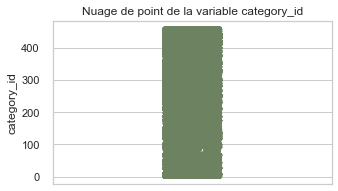

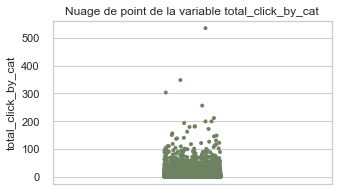

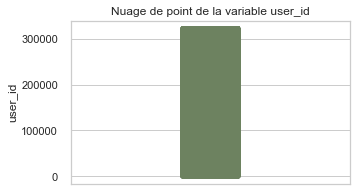

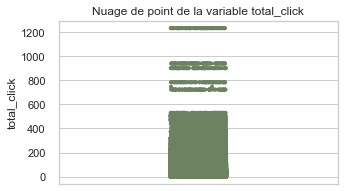

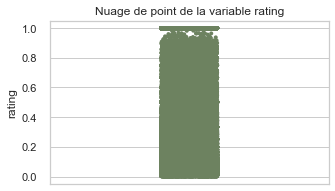

In [ ]:
for col in dfs_agg.select_dtypes(include=['float64', 'int']).columns:
    pk.graph_stripplot(dfs_agg,col, "Nuage de point de la variable "+col,(5,3),"#6D8260")

Nous observons quelques clicks important par rapport aux autres données,  mais cela reste raisonnable. <br>Traçons des boites à moustache pour avoir plus d'informations sur la dispersion des données au sein des variables

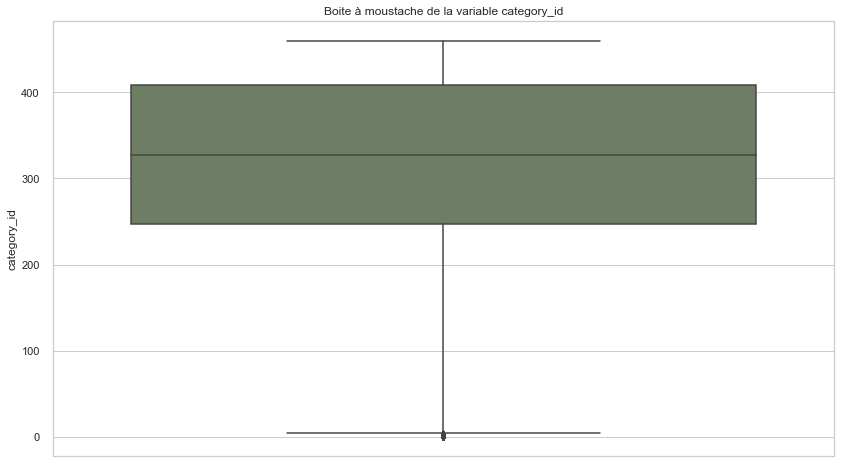

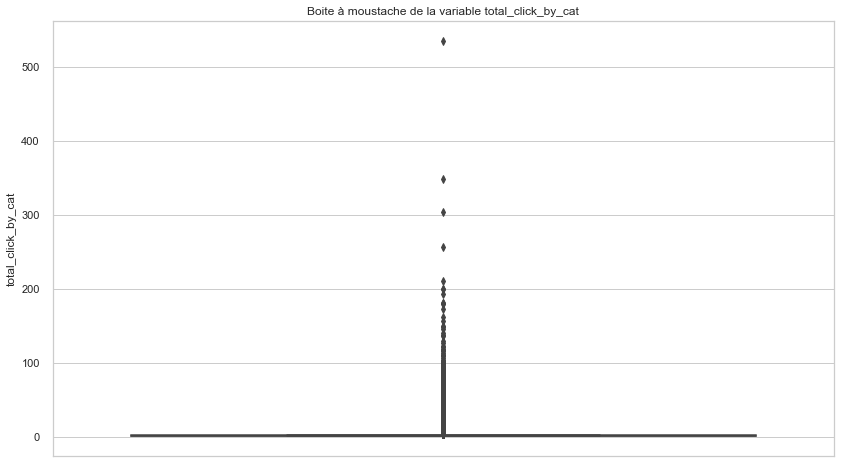

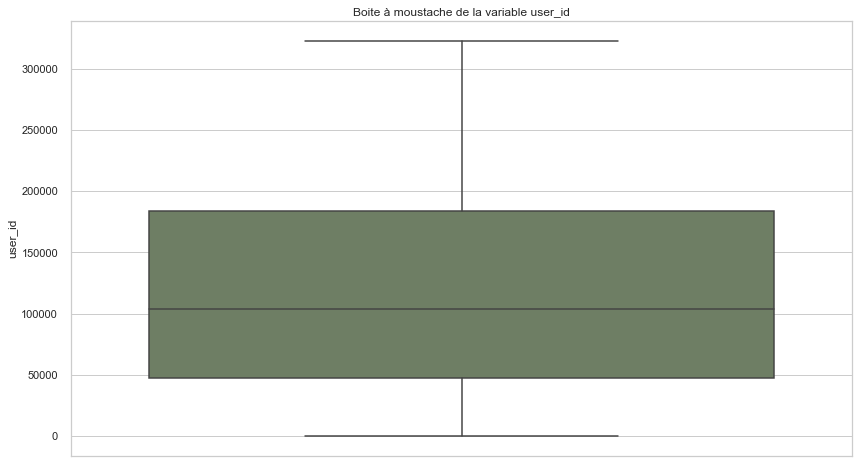

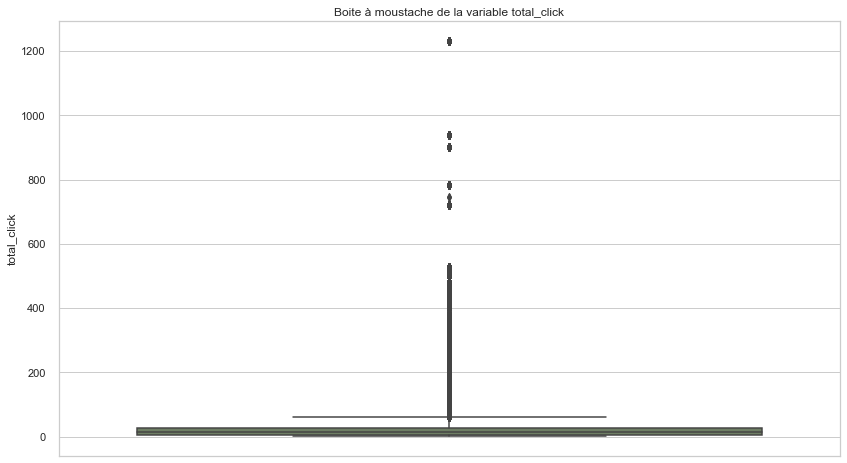

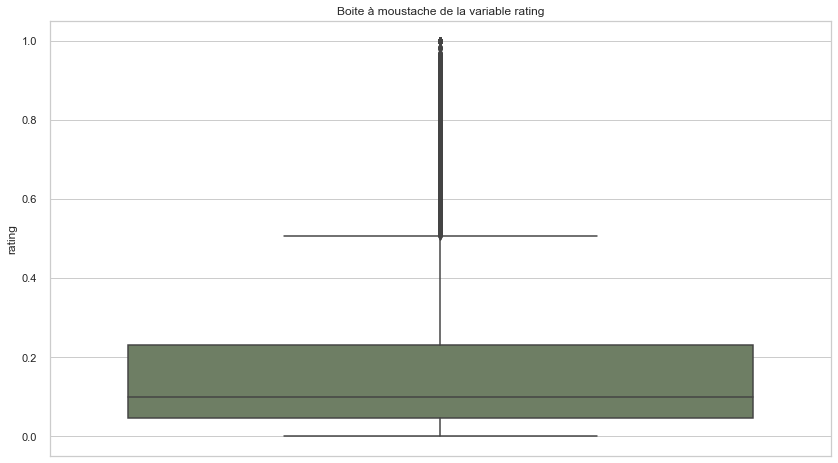

In [ ]:
for col in dfs_agg.select_dtypes(include=['float64', 'int']).columns:
    pk.graph_boxplot(dfs_agg, col, "Boite à moustache de la variable "+col, "#6D8260", (14,8))

Les données sont peu dispersées au sein de nos variables les boites sont plutôt aplaties. Il existe quelques valeurs extrêmes. Mais nous décidons de les conserver car elles semblent possible.

In [ ]:
dfs_agg.describe()

total_click        user_id    category_id  total_click_by_cat  \
count  322897.000000  322897.000000  322897.000000       322897.000000   
mean        9.254285   14478.941093     298.650474            1.872575   
std        14.946358    8737.849175     119.283795            2.893215   
min         2.000000       0.000000       1.000000            1.000000   
25%         2.000000    6856.000000     231.000000            1.000000   
50%         4.000000   14229.000000     327.000000            1.000000   
75%        10.000000   22061.000000     409.000000            2.000000   
max      1232.000000   30279.000000     460.000000          535.000000   

              rating  
count  322897.000000  
mean        0.483945  
std         1.030742  
min         0.001111  
25%         0.125000  
50%         0.285714  
75%         0.500000  
max       267.500000

Regardons la distribution de la variable total_click

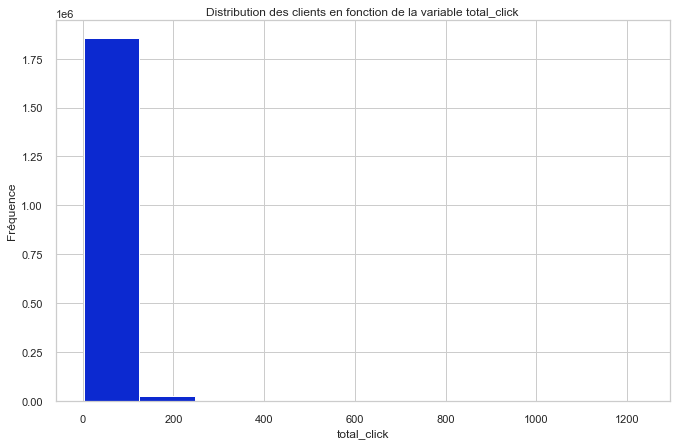

In [ ]:
pk.graph_hist_interval_auto(dfs_agg['total_click'],
                                "Distribution des clients en fonction de la variable total_click",
                                "#0C29D0","total_click", "Fréquence")

La distribution est concentrée à gauche du graphique.

Etudions la distribution de la variable rating (le taux de clicks par catégorie des clients)

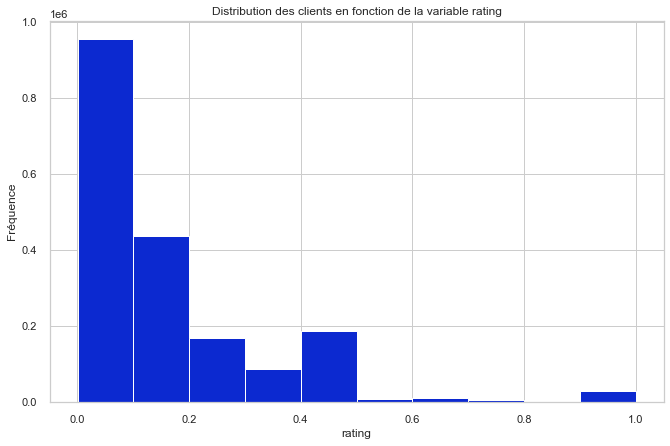

In [ ]:
pk.graph_hist_interval_auto(dfs_agg['rating'],
                                "Distribution des clients en fonction de la variable rating",
                                "#0C29D0","rating", "Fréquence")

Nous observons que les clients ont plutôt à regarder plusieurs catégories. En effet, plus de 80% des clients ont des catégories avec un taux de clicks entre 0.0 et 0.1. 

Etudions les catégories visitées par les utilisateurs.

In [ ]:
dfs_agg["category_id"].value_counts(normalize=True).head(20)

281    0.079034
375    0.065527
412    0.052364
437    0.048775
399    0.036973
250    0.035248
331    0.032025
209    0.029016
418    0.026094
323    0.024484
421    0.023483
118    0.022748
26     0.019889
409    0.019243
431    0.018379
136    0.018360
428    0.018346
442    0.017808
327    0.017589
301    0.016392
Name: category_id, dtype: float64

Les visites des utilisateurs semblent assez dispersées dans les catégories.

Faisons un regroupement.

In [48]:
info_lib=(dfs_agg["category_id"].value_counts(normalize=True)>=0.02)

In [49]:
info_lib.value_counts(normalize=True)

False    0.962025
True     0.037975
Name: category_id, dtype: float64

In [50]:
info_lib=list(info_lib.loc[info_lib== True].index)

In [51]:
def map_lib(lib):
    if lib in info_lib:
        return lib
    else:
        return "99"

In [52]:
dfs_agg["category_id_reg"]=dfs_agg["category_id"].map(map_lib, na_action=None)

In [53]:
dfs_agg["category_id_reg"].value_counts(normalize=True)

99     0.524230
281    0.079034
375    0.065527
412    0.052364
437    0.048775
399    0.036973
250    0.035248
331    0.032025
209    0.029016
418    0.026094
323    0.024484
421    0.023483
118    0.022748
Name: category_id_reg, dtype: float64

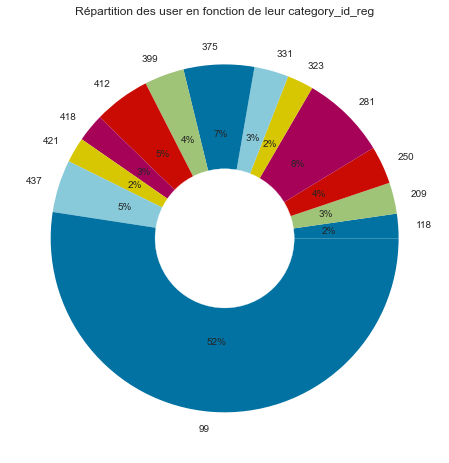

In [54]:
pk.graph_circle(dfs_agg["category_id_reg"], "category_id_reg", "Répartition des user en fonction de leur category_id_reg")

Les catégorie les plus visitées sont 375 et 281. En effet, la catégorie 375 est visitée par 7% des clients et la catégorie 281 par 8% des clients.

In [55]:
import gc

gc.collect()

4365

Maintenant que nous connaissons nos données, nous pouvons passer à la réalisation du système de recommandation.

## Système de recommandation

Il existe plusieurs types de recommandation :
- Content-based : suggérez des éléments similaires en fonction d'un élément particulier. Ce système utilise des métadonnées d'éléments, telles que le genre, le réalisateur, la description, les acteurs, etc. pour les films, pour faire ces recommandations. L'idée générale derrière ces systèmes de recommandation est que si une personne aime un article particulier, elle aimera également un article qui lui est similaire. Et pour le recommander, il utilisera les métadonnées des éléments passés de l'utilisateur. Un bon exemple pourrait être YouTube, où en fonction de votre historique, il vous suggère de nouvelles vidéos que vous pourriez potentiellement regarder.
- Collaborative filtered :ces systèmes sont largement utilisés et tentent de prédire la note ou la préférence qu'un utilisateur donnerait à un élément en fonction des notes et des préférences passées des autres utilisateurs. Les filtres collaboratifs ne nécessitent pas de métadonnées d'élément comme leurs homologues basés sur le contenu.

Ici nous allons tester ces deux types de recommandation.

### Content based system recommendation

Chargeons l'embedding donné

In [ ]:
dfs

user_id        session_id  session_start session_size click_timestamp  \
0             0  1506825423271737  1506825423000            2   1506826828020   
1             0  1506825423271737  1506825423000            2   1506826858020   
2             1  1506825426267738  1506825426000            2   1506827017951   
3             1  1506825426267738  1506825426000            2   1506827047951   
4             2  1506825435299739  1506825435000            2   1506827090575   
...         ...               ...            ...          ...             ...   
2988176   10051  1508211372158328  1508211372000            2   1508211557302   
2988177  322896  1508211376302329  1508211376000            2   1508211672520   
2988178  322896  1508211376302329  1508211376000            2   1508211702520   
2988179  123718  1508211379189330  1508211379000            2   1508211513583   
2988180  123718  1508211379189330  1508211379000            2   1508211543583   

        click_environment click_deviceGroup click_os click_country  \
0                       4                 3       20             1   
1                       4                 3       20             1   
2                       4                 1       17             1   
3                       4                 1       17             1   
4                       4                 1       17             1   
...                   ...               ...      ...           ...   
2988176                 4                 3        2             1   
2988177                 4                 1       17             1   
2988178                 4                 1       17             1   
2988179                 4                 3        2             1   
2988180                 4                 3        2             1   

        click_region click_referrer_type  \
0                 20                   2   
1                 20                   2   
2                 16                   2   
3                 16                   2   
4                 24                   2   
...              ...                 ...   
2988176           25                   1   
2988177           25                   2   
2988178           25                   2   
2988179           25                   2   
2988180           25                   2   

                                            file click_article_id  \
0        Input\clicks\clicks\clicks_hour_000.csv           157541   
1        Input\clicks\clicks\clicks_hour_000.csv            68866   
2        Input\clicks\clicks\clicks_hour_000.csv           235840   
3        Input\clicks\clicks\clicks_hour_000.csv            96663   
4        Input\clicks\clicks\clicks_hour_000.csv           119592   
...                                          ...              ...   
2988176  Input\clicks\clicks\clicks_hour_384.csv            84911   
2988177  Input\clicks\clicks\clicks_hour_384.csv            30760   
2988178  Input\clicks\clicks\clicks_hour_384.csv           157507   
2988179  Input\clicks\clicks\clicks_hour_384.csv           234481   
2988180  Input\clicks\clicks\clicks_hour_384.csv           233578   

         category_id  created_at_ts  publisher_id  words_count  
0                281  1506800518000             0          280  
1                136  1506816482000             0          226  
2                375  1506807839000             0          159  
3                209  1506788025000             0          206  
4                247  1506784316000             0          239  
...              ...            ...           ...          ...  
2988176          174  1508187619000             0          171  
2988177           26  1508185091000             0          162  
2988178          281  1508236945000             0          370  
2988179          375  1508181572000             0          212  
2988180          375  1508176010000             0          174  

[2988181 rows x 17 columns]

In [56]:
arts = dfs["click_article_id"].value_counts().index

In [57]:
dfs["click_article_id"].value_counts()

160974    37213
272143    28943
336221    23851
234698    23499
123909    23122
          ...  
3306          1
166713        1
214721        1
350088        1
98243         1
Name: click_article_id, Length: 46033, dtype: int64

In [58]:
articles["click_article_id"].value_counts()

0         1
242727    1
242703    1
242702    1
242701    1
         ..
121347    1
121346    1
121345    1
121344    1
364046    1
Name: click_article_id, Length: 364047, dtype: int64

In [59]:
arts

Int64Index([160974, 272143, 336221, 234698, 123909, 336223,  96210, 162655,
            183176, 168623,
            ...
             15321, 296434, 296397, 350748, 106815,   3306, 166713, 214721,
            350088,  98243],
           dtype='int64', length=46033)

In [60]:
import gc

gc.collect()

0

In [61]:
articles["publisher_id"].nunique()

1

In [62]:
del articles["publisher_id"]

articles_embeddings.pickle Pickle (Python 3) of a NumPy matrix containing the Article Content Embeddings (250-dimensional vectors), trained upon articles' text and metadata by the CHAMELEON's ACR module (see paper for details) for 364047 published articles.

In [63]:
art_embed.shape

(364047, 250)

In [64]:
arts

Int64Index([160974, 272143, 336221, 234698, 123909, 336223,  96210, 162655,
            183176, 168623,
            ...
             15321, 296434, 296397, 350748, 106815,   3306, 166713, 214721,
            350088,  98243],
           dtype='int64', length=46033)

In [65]:
art_embed = art_embed[arts]
art_embed.shape

(46033, 250)

Pour réduire, nous pouvons réaliser une ACP.

Essayons de visualiser nos données grâce à une analyse en composante principale. Ceci nous permettra de voir combien de dimensions il nous faudrait pour expliquer nos données. 

In [66]:
Z=pk_multi.amulti_acp_standard(art_embed)

250
[2.40739479e+01 1.78660774e+01 1.62346420e+01 1.33008299e+01
 1.07090616e+01 1.04431839e+01 8.69035149e+00 8.07654667e+00
 7.93012333e+00 6.87234879e+00 6.64398527e+00 6.41533279e+00
 5.87584305e+00 5.82609797e+00 5.18944168e+00 5.12258625e+00
 4.82030106e+00 4.36716795e+00 4.20207214e+00 4.00714922e+00
 3.85181713e+00 3.56260180e+00 3.46776319e+00 3.29411602e+00
 3.05131054e+00 2.96187019e+00 2.83383489e+00 2.61336112e+00
 2.46915364e+00 2.34730935e+00 2.30101132e+00 2.04780412e+00
 2.03015685e+00 1.88269591e+00 1.83394945e+00 1.73276639e+00
 1.66845810e+00 1.64226341e+00 1.55971181e+00 1.44403243e+00
 1.35433328e+00 1.31429684e+00 1.22606397e+00 1.10551155e+00
 1.08171523e+00 1.06757557e+00 9.94001567e-01 9.42357779e-01
 8.59958053e-01 8.31448615e-01 7.63228416e-01 7.08506942e-01
 6.54280603e-01 5.96485913e-01 5.90217650e-01 5.46654046e-01
 5.25260746e-01 4.72392857e-01 4.41375226e-01 4.07439679e-01
 3.52047831e-01 3.47139299e-01 3.13106179e-01 2.92558104e-01
 2.74097979e-01 2.54

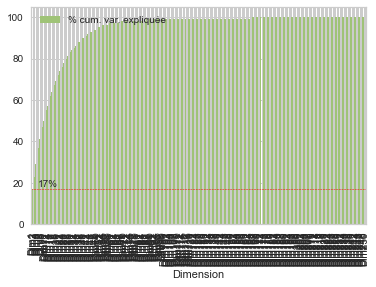

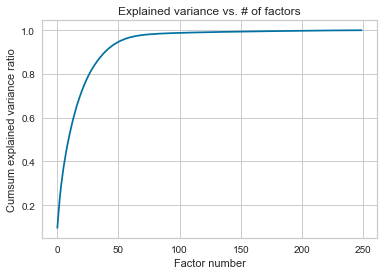

In [67]:
pk_multi.amulti_acp_choice_dim(art_embed, Z)

In [68]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def amultiacp_visualizer_without_sticker(Z, dim):
    """
    Trace les graphiques pour visualiser les dimensions soit en 3d soit du premier plan factoriel
    
    Args:
        data_acp ([type]): données
        Z ([type]): données transformées
        dim([type]): nombre de dimensions retenues
        data_study([type]): toutes les données (qui contient les étiquettes)    
    """   
    pca = PCA(n_components=dim)
    #calculs
    WGI_pca = pca.fit_transform(Z)
    # Transformation en DataFrame pandas
    WGI_pca_df = pd.DataFrame({
        "Dim1" : WGI_pca[:,0], 
        "Dim2" : WGI_pca[:,1],
        "Dim3" : WGI_pca[:,2]
    })

    # Résultat (premières lignes)
    #WGI_pca_df.head()
    WGI_pca_df.plot.scatter("Dim1", "Dim2") # nuage de points
    plt.xlabel("Dimension 1 ") # modification du nom de l'axe X
    plt.ylabel("Dimension 2 ") # idem pour axe Y
    plt.suptitle("Premier plan factoriel") # titre général
    plt.show()
    
    ax = plt.figure(figsize=(16,10))
    ax = plt.axes(projection='3d')
    ax.scatter(
        xs=WGI_pca_df["Dim1"], 
        ys=WGI_pca_df["Dim2"], 
        zs=WGI_pca_df["Dim3"]
    )
    ax.set_xlabel('Dim 1 ')
    ax.set_ylabel('Dim 2')
    ax.set_zlabel('Dim 3')
    plt.show()
    return WGI_pca

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


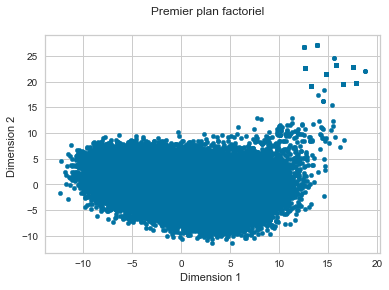

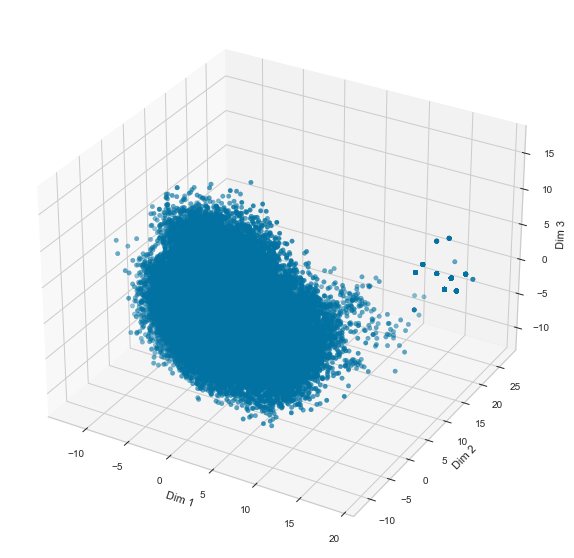

In [69]:
df_reduced = amultiacp_visualizer_without_sticker(Z, 0.80)

In [70]:
df_reduced.shape

(46033, 28)

In [71]:
df_reduced

array([[ 4.4098177 , -6.6391215 ,  0.9264275 , ...,  0.09995237,
         1.1843977 , -0.944156  ],
       [ 0.36574778, -1.0395323 , -5.7289834 , ..., -3.1537986 ,
        -0.30937946, -0.4867472 ],
       [ 1.9663274 , -0.41570544,  1.0472239 , ...,  2.9465492 ,
        -0.86912507, -0.1443288 ],
       ...,
       [ 3.5872054 , -4.1287723 ,  5.1783967 , ..., -0.15219103,
         1.8937479 , -1.25646   ],
       [-6.28472   , -2.794149  ,  1.3202729 , ..., -1.4334401 ,
         2.691557  ,  0.3305952 ],
       [18.77465   , 22.010057  ,  0.1623888 , ..., -0.44788945,
        -0.3230339 , -1.3871859 ]], dtype=float32)

In [72]:
df_reduced_2 = pd.DataFrame(df_reduced)

In [73]:
df_reduced_2 = df_reduced_2.reset_index()

In [74]:
articles.shape

(364047, 4)

In [75]:
arts.shape

(46033,)

In [76]:
df_arts = pd.DataFrame(arts)

In [77]:
df_arts

0
0      160974
1      272143
2      336221
3      234698
4      123909
...       ...
46028    3306
46029  166713
46030  214721
46031  350088
46032   98243

[46033 rows x 1 columns]

In [78]:
df_arts = df_arts.reset_index()

In [79]:
df_arts.columns= ['index', 'article_id']

In [80]:
df_arts_embedd_acp = df_arts.join(df_reduced_2, how='left', on='index', lsuffix="_1")


In [81]:
del df_arts_embedd_acp["index_1"]

In [82]:
del df_arts_embedd_acp["index"]

In [83]:
gc.collect()

46710

In [84]:
df_arts_embedd_acp.head(2)

article_id         0         1         2         3         4         5  \
0      160974  4.409818 -6.639122  0.926427  2.431026  0.762038  1.969448   
1      272143  0.365748 -1.039532 -5.728983  1.457015  1.994284 -2.534556   

          6         7         8  ...        18        19        20        21  \
0 -5.136955 -6.181464  0.567569  ... -1.453939  0.118815  0.335479 -0.070646   
1  1.640267 -0.554919  0.891390  ... -1.248821  5.384028  1.423406  2.994571   

         22        23        24        25        26        27  
0  1.174920 -0.108625 -1.098951  0.099952  1.184398 -0.944156  
1 -0.059741  0.665796  0.391135 -3.153799 -0.309379 -0.486747  

[2 rows x 29 columns]

In [85]:
#df_arts_embedd_acp.to_csv("Output\\data\\df_arts_embedd_acp.csv")

In [86]:
import pandas as pd
import numpy as np

In [87]:
df_arts_embedd_acp = pd.read_csv("Output\\data\\df_arts_embedd_acp.csv", dtype=np.float64)

In [88]:
df_arts_embedd_acp.head(2)

Unnamed: 0  article_id         0         1         2         3         4  \
0         0.0    160974.0  4.409818 -6.639121  0.926427  2.431026  0.762038   
1         1.0    272143.0  0.365748 -1.039532 -5.728983  1.457015  1.994284   

          5         6         7  ...        42        43        44        45  \
0  1.969448 -5.136955 -6.181464  ...  0.237882 -0.540912  1.435337 -0.288822   
1 -2.534556  1.640267 -0.554919  ... -0.053396 -0.227845  0.915504 -0.885325   

         46        47        48        49        50        51  
0  0.012102 -1.249337  0.632119 -0.078331 -0.289892  0.233789  
1 -0.934312 -1.385366  0.871939 -0.929860 -0.500829 -0.358487  

[2 rows x 54 columns]

In [89]:
del df_arts_embedd_acp["Unnamed: 0"]

In [90]:
arts_embedd_acp = df_arts_embedd_acp[[ '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51']]

In [91]:
arts_embedd_acp = arts_embedd_acp[[ '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51']].to_numpy(dtype = np.float32)

In [92]:
arts_embedd_acp[0].shape

(52,)

Nous créons une fonction pour récupérer un utilisateur

In [93]:
dfs

user_id        session_id  session_start session_size click_timestamp  \
0             0  1506825423271737  1506825423000            2   1506826828020   
1             0  1506825423271737  1506825423000            2   1506826858020   
2             1  1506825426267738  1506825426000            2   1506827017951   
3             1  1506825426267738  1506825426000            2   1506827047951   
4             2  1506825435299739  1506825435000            2   1506827090575   
...         ...               ...            ...          ...             ...   
2988176   10051  1508211372158328  1508211372000            2   1508211557302   
2988177  322896  1508211376302329  1508211376000            2   1508211672520   
2988178  322896  1508211376302329  1508211376000            2   1508211702520   
2988179  123718  1508211379189330  1508211379000            2   1508211513583   
2988180  123718  1508211379189330  1508211379000            2   1508211543583   

        click_environment click_deviceGroup click_os click_country  \
0                       4                 3       20             1   
1                       4                 3       20             1   
2                       4                 1       17             1   
3                       4                 1       17             1   
4                       4                 1       17             1   
...                   ...               ...      ...           ...   
2988176                 4                 3        2             1   
2988177                 4                 1       17             1   
2988178                 4                 1       17             1   
2988179                 4                 3        2             1   
2988180                 4                 3        2             1   

        click_region click_referrer_type  \
0                 20                   2   
1                 20                   2   
2                 16                   2   
3                 16                   2   
4                 24                   2   
...              ...                 ...   
2988176           25                   1   
2988177           25                   2   
2988178           25                   2   
2988179           25                   2   
2988180           25                   2   

                                            file click_article_id  \
0        Input\clicks\clicks\clicks_hour_000.csv           157541   
1        Input\clicks\clicks\clicks_hour_000.csv            68866   
2        Input\clicks\clicks\clicks_hour_000.csv           235840   
3        Input\clicks\clicks\clicks_hour_000.csv            96663   
4        Input\clicks\clicks\clicks_hour_000.csv           119592   
...                                          ...              ...   
2988176  Input\clicks\clicks\clicks_hour_384.csv            84911   
2988177  Input\clicks\clicks\clicks_hour_384.csv            30760   
2988178  Input\clicks\clicks\clicks_hour_384.csv           157507   
2988179  Input\clicks\clicks\clicks_hour_384.csv           234481   
2988180  Input\clicks\clicks\clicks_hour_384.csv           233578   

         category_id  created_at_ts  publisher_id  words_count  
0                281  1506800518000             0          280  
1                136  1506816482000             0          226  
2                375  1506807839000             0          159  
3                209  1506788025000             0          206  
4                247  1506784316000             0          239  
...              ...            ...           ...          ...  
2988176          174  1508187619000             0          171  
2988177           26  1508185091000             0          162  
2988178          281  1508236945000             0          370  
2988179          375  1508181572000             0          212  
2988180          375  1508176010000             0          174  

[2988181 rows x 17 columns]

In [94]:
#dfs.to_csv("Output\\data\\dfs.csv")

In [95]:
import pandas as pd

dfs = pd.read_csv("Output\\data\\dfs.csv")

In [96]:
dfs

Unnamed: 0  user_id        session_id  session_start  session_size  \
0                 0        0  1506825423271737  1506825423000             2   
1                 1        0  1506825423271737  1506825423000             2   
2                 2        1  1506825426267738  1506825426000             2   
3                 3        1  1506825426267738  1506825426000             2   
4                 4        2  1506825435299739  1506825435000             2   
...             ...      ...               ...            ...           ...   
2988176     2988176    10051  1508211372158328  1508211372000             2   
2988177     2988177   322896  1508211376302329  1508211376000             2   
2988178     2988178   322896  1508211376302329  1508211376000             2   
2988179     2988179   123718  1508211379189330  1508211379000             2   
2988180     2988180   123718  1508211379189330  1508211379000             2   

         click_timestamp  click_environment  click_deviceGroup  click_os  \
0          1506826828020                  4                  3        20   
1          1506826858020                  4                  3        20   
2          1506827017951                  4                  1        17   
3          1506827047951                  4                  1        17   
4          1506827090575                  4                  1        17   
...                  ...                ...                ...       ...   
2988176    1508211557302                  4                  3         2   
2988177    1508211672520                  4                  1        17   
2988178    1508211702520                  4                  1        17   
2988179    1508211513583                  4                  3         2   
2988180    1508211543583                  4                  3         2   

         click_country  click_region  click_referrer_type  \
0                    1            20                    2   
1                    1            20                    2   
2                    1            16                    2   
3                    1            16                    2   
4                    1            24                    2   
...                ...           ...                  ...   
2988176              1            25                    1   
2988177              1            25                    2   
2988178              1            25                    2   
2988179              1            25                    2   
2988180              1            25                    2   

                                            file  click_article_id  \
0        Input\clicks\clicks\clicks_hour_000.csv            157541   
1        Input\clicks\clicks\clicks_hour_000.csv             68866   
2        Input\clicks\clicks\clicks_hour_000.csv            235840   
3        Input\clicks\clicks\clicks_hour_000.csv             96663   
4        Input\clicks\clicks\clicks_hour_000.csv            119592   
...                                          ...               ...   
2988176  Input\clicks\clicks\clicks_hour_384.csv             84911   
2988177  Input\clicks\clicks\clicks_hour_384.csv             30760   
2988178  Input\clicks\clicks\clicks_hour_384.csv            157507   
2988179  Input\clicks\clicks\clicks_hour_384.csv            234481   
2988180  Input\clicks\clicks\clicks_hour_384.csv            233578   

         category_id  created_at_ts  publisher_id  words_count  
0                281  1506800518000             0          280  
1                136  1506816482000             0          226  
2                375  1506807839000             0          159  
3                209  1506788025000             0          206  
4                247  1506784316000             0          239  
...              ...            ...           ...          ...  
2988176          174  1508187619000             0          171  
2988177           26  1508185091000             0    

In [97]:
dfs["click_article_id"].value_counts()

160974    37213
272143    28943
336221    23851
234698    23499
123909    23122
          ...  
3306          1
166713        1
214721        1
350088        1
98243         1
Name: click_article_id, Length: 46033, dtype: int64

In [134]:
arts = dfs["click_article_id"].value_counts().index

In [135]:
arts

Int64Index([160974, 272143, 336221, 234698, 123909, 336223,  96210, 162655,
            183176, 168623,
            ...
             15321, 296434, 296397, 350748, 106815,   3306, 166713, 214721,
            350088,  98243],
           dtype='int64', length=46033)

In [100]:
dfs_user_art = dfs.groupby(["user_id", "click_article_id"])["click_article_id"].count().reset_index(name="nb_click_by_arts")

In [101]:
#dfs_user_art.to_csv("Output\\data\\dfs_user_art.csv")

In [102]:
dfs_user_art = pd.read_csv("Output\\data\\dfs_user_art.csv")

In [103]:
import gc
gc.collect()

0

In [104]:
def user(x):
    user = dfs_user_art.loc[dfs_user_art['user_id']==x]
    if len(user)>0:
        return user
    return np.nan

In [105]:
test = user(10)

Nous calculons la similarité avec le cosinus.

In [106]:
gc.collect()

0

In [146]:
arts_embedd_acp.shape

(46033, 52)

In [108]:
df_reduced

array([[ 4.4098177 , -6.6391215 ,  0.9264275 , ...,  0.09995237,
         1.1843977 , -0.944156  ],
       [ 0.36574778, -1.0395323 , -5.7289834 , ..., -3.1537986 ,
        -0.30937946, -0.4867472 ],
       [ 1.9663274 , -0.41570544,  1.0472239 , ...,  2.9465492 ,
        -0.86912507, -0.1443288 ],
       ...,
       [ 3.5872054 , -4.1287723 ,  5.1783967 , ..., -0.15219103,
         1.8937479 , -1.25646   ],
       [-6.28472   , -2.794149  ,  1.3202729 , ..., -1.4334401 ,
         2.691557  ,  0.3305952 ],
       [18.77465   , 22.010057  ,  0.1623888 , ..., -0.44788945,
        -0.3230339 , -1.3871859 ]], dtype=float32)

In [11]:
df_cosine_sim = pd.DataFrame(cosine_sim)

In [12]:
df_cosine_sim.to_csv("Output\\df_cosine_sim.csv")

In [ ]:
df_cosine_sim = pd.read_csv(df_cosine_sim, dtype=np.float64)

In [145]:
gc.collect()

1166

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(arts_embedd_acp)
#cosine_sim[:4, :4]

In [17]:
cosine_sim.shape

(46033, 46033)

In [18]:
cosine_sim

array([[ 1.0000005 ,  0.15210068, -0.10197259, ...,  0.4874342 ,
        -0.20601918, -0.0528254 ],
       [ 0.15210068,  1.0000001 , -0.05473976, ...,  0.05398577,
        -0.18396282, -0.03892947],
       [-0.10197259, -0.05473976,  1.        , ...,  0.14951749,
        -0.01694245, -0.03653489],
       ...,
       [ 0.4874342 ,  0.05398577,  0.14951749, ...,  0.9999999 ,
         0.01652496,  0.01798389],
       [-0.20601918, -0.18396282, -0.01694245, ...,  0.01652496,
         1.0000001 , -0.34249857],
       [-0.0528254 , -0.03892947, -0.03653489, ...,  0.01798389,
        -0.34249857,  1.        ]], dtype=float32)

In [ ]:
dfs_user_art['click_article_id'].shape

(2950710,)

In [128]:
arts = pd.DataFrame(arts)

In [112]:
arts

Int64Index([160974, 272143, 336221, 234698, 123909, 336223,  96210, 162655,
            183176, 168623,
            ...
             15321, 296434, 296397, 350748, 106815,   3306, 166713, 214721,
            350088,  98243],
           dtype='int64', length=46033)

In [130]:
ind_i = pd.Series(arts.index, index=arts[0])

In [131]:
ind_i

0
160974        0
272143        1
336221        2
234698        3
123909        4
          ...  
3306      46028
166713    46029
214721    46030
350088    46031
98243     46032
Length: 46033, dtype: int64

In [136]:
titles = dfs_user_art['click_article_id']
indices = pd.Series(range(0,46033), index=arts)

In [137]:
indices

160974        0
272143        1
336221        2
234698        3
123909        4
          ...  
3306      46028
166713    46029
214721    46030
350088    46031
98243     46032
Length: 46033, dtype: int64

In [138]:
gc.collect()

3236

In [139]:
cosine_sim.shape

(46033, 46033)

Livre recommandé

In [140]:
def arts_recommendations(x):
    idx = indices[x]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return sim_scores#x.iloc[movie_indices]

Livres recommandés par user

In [141]:
def user_recommendation(x):
    reco = []
    user_arts = user(x)
    for art in user_arts["click_article_id"]:
        livre = arts_recommendations(art)
        reco.append(livre[0])
    sim_scores = sorted(reco, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:6]
    return sim_scores

Test d'un user

In [142]:
user_recommendation(0)

[(36168, 0.90600806),
 (28168, 0.89542997),
 (441, 0.88989717),
 (36326, 0.8767515),
 (4483, 0.80455023)]

In [147]:
gc.collect()

7

Nous avons pu facilement réaliser un algorithme afin d'obtenir des recommandations par utilisateur basé sur le contenu. Passons à une méthode plus poussé avec l'utilisation de modèle : le filtering collaborative

###  collaborative Filtering

KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

SVD : L'un des systèmes de recommandation les plus puissants est le modèle SVD. SVD est une forme de factorisation matricielle qui utilise la descente de gradient pour créer des prédictions pour les notes des utilisateurs, tout en minimisant l'erreur entre les notes prédites et les notes réelles de notre matrice d'utilité d'origine. En conséquence, la descente de gradient minimise la RMSE lors de la prédiction de ces nouvelles notes.

NMF :  NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.

In [ ]:
dfs_user_art.head(2)

user_id  click_article_id  nb_click_by_arts
0        0             68866                 1
1        0             87205                 1

In [ ]:
dfs_user_art

user_id  click_article_id  nb_click_by_arts
0              0             68866                 1
1              0             87205                 1
2              0             87224                 1
3              0             96755                 1
4              0            157541                 1
...          ...               ...               ...
2950705   322894            168401                 1
2950706   322895             63746                 1
2950707   322895            289197                 1
2950708   322896             30760                 1
2950709   322896            157507                 1

[2950710 rows x 3 columns]

In [24]:
articles.column = ["click_article_id", "category_id", "created_at_ts", "words_count"]

C:\Users\aurel\AppData\Local\Temp\ipykernel_20736\2005646722.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  articles.column = ["click_article_id", "category_id", "created_at_ts", "words_count"]


In [25]:
dfs_agg_info = dfs_user_art.join(articles, how='left', on='click_article_id', lsuffix="_1")

In [26]:
dfs_agg_info

Unnamed: 0  user_id  click_article_id_1  nb_click_by_arts  \
0                 0        0               68866                 1   
1                 1        0               87205                 1   
2                 2        0               87224                 1   
3                 3        0               96755                 1   
4                 4        0              157541                 1   
...             ...      ...                 ...               ...   
2950705     2950705   322894              168401                 1   
2950706     2950706   322895               63746                 1   
2950707     2950707   322895              289197                 1   
2950708     2950708   322896               30760                 1   
2950709     2950709   322896              157507                 1   

         click_article_id  category_id  created_at_ts  publisher_id  \
0                   68866          136  1506816482000             0   
1                   87205          186  1507497786000             0   
2                   87224          186  1507496527000             0   
3                   96755          209  1507326628000             0   
4                  157541          281  1506800518000             0   
...                   ...          ...            ...           ...   
2950705            168401          297  1507663321000             0   
2950706             63746          133  1508142585000             0   
2950707            289197          418  1508179909000             0   
2950708             30760           26  1508185091000             0   
2950709            157507          281  1508236945000             0   

         words_count  
0                226  
1                137  
2                100  
3                211  
4                280  
...              ...  
2950705          215  
2950706          162  
2950707          176  
2950708          162  
2950709          370  

[2950710 rows x 9 columns]

In [27]:
total_click = dfs_agg[["user_id", "category_id", "rating" ,"total_click"]].drop_duplicates()

In [28]:
total_click.column = ["user_id", "category_id", "rating_cat" ,"total_click"]

C:\Users\aurel\AppData\Local\Temp\ipykernel_20736\574683373.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  total_click.column = ["user_id", "category_id", "rating_cat" ,"total_click"]


In [29]:
total_click

user_id  category_id  rating  total_click
0              0          136   0.125            8
1              0          186   0.250            8
2              0          209   0.125            8
3              0          281   0.250            8
4              0          375   0.125            8
...          ...          ...     ...          ...
1882297   322894          297   0.500            2
1882298   322895          133   0.500            2
1882299   322895          418   0.500            2
1882300   322896           26   0.500            2
1882301   322896          281   0.500            2

[1882302 rows x 4 columns]

In [30]:
dfs_agg_info_2 = dfs_agg_info.merge(total_click, how='left', on=["user_id", 'category_id'])

In [31]:
dfs_agg_info.shape

(2950710, 9)

In [32]:
dfs_agg_info_2.shape

(2950710, 11)

In [33]:
dfs_agg_info_2.loc[dfs_agg_info_2["user_id"]==0]

Unnamed: 0  user_id  click_article_id_1  nb_click_by_arts  \
0           0        0               68866                 1   
1           1        0               87205                 1   
2           2        0               87224                 1   
3           3        0               96755                 1   
4           4        0              157541                 1   
5           5        0              160158                 1   
6           6        0              233470                 1   
7           7        0              313996                 1   

   click_article_id  category_id  created_at_ts  publisher_id  words_count  \
0             68866          136  1506816482000             0          226   
1             87205          186  1507497786000             0          137   
2             87224          186  1507496527000             0          100   
3             96755          209  1507326628000             0          211   
4            157541          281  1506800518000             0          280   
5            160158          281  1507352746000             0          145   
6            233470          375  1507375559000             0          292   
7            313996          431  1507317197000             0          265   

   rating  total_click  
0   0.125            8  
1   0.250            8  
2   0.250            8  
3   0.125            8  
4   0.250            8  
5   0.250            8  
6   0.125            8  
7   0.125            8

In [34]:
del dfs_agg_info_2["click_article_id_1"]

In [35]:
del dfs_agg_info_2["created_at_ts"]

In [36]:
dfs_agg_info_2.loc[dfs_agg_info_2["user_id"]==0]

Unnamed: 0  user_id  nb_click_by_arts  click_article_id  category_id  \
0           0        0                 1             68866          136   
1           1        0                 1             87205          186   
2           2        0                 1             87224          186   
3           3        0                 1             96755          209   
4           4        0                 1            157541          281   
5           5        0                 1            160158          281   
6           6        0                 1            233470          375   
7           7        0                 1            313996          431   

   publisher_id  words_count  rating  total_click  
0             0          226   0.125            8  
1             0          137   0.250            8  
2             0          100   0.250            8  
3             0          211   0.125            8  
4             0          280   0.250            8  
5             0          145   0.250            8  
6             0          292   0.125            8  
7             0          265   0.125            8

In [37]:
dfs_agg_info_2['rating_art'] = dfs_agg_info_2['nb_click_by_arts'] / dfs_agg_info_2['total_click']

In [38]:
dfs_agg_info_2

Unnamed: 0  user_id  nb_click_by_arts  click_article_id  category_id  \
0                 0        0                 1             68866          136   
1                 1        0                 1             87205          186   
2                 2        0                 1             87224          186   
3                 3        0                 1             96755          209   
4                 4        0                 1            157541          281   
...             ...      ...               ...               ...          ...   
2950705     2950705   322894                 1            168401          297   
2950706     2950706   322895                 1             63746          133   
2950707     2950707   322895                 1            289197          418   
2950708     2950708   322896                 1             30760           26   
2950709     2950709   322896                 1            157507          281   

         publisher_id  words_count  rating  total_click  rating_art  
0                   0          226   0.125            8       0.125  
1                   0          137   0.250            8       0.125  
2                   0          100   0.250            8       0.125  
3                   0          211   0.125            8       0.125  
4                   0          280   0.250            8       0.125  
...               ...          ...     ...          ...         ...  
2950705             0          215   0.500            2       0.500  
2950706             0          162   0.500            2       0.500  
2950707             0          176   0.500            2       0.500  
2950708             0          162   0.500            2       0.500  
2950709             0          370   0.500            2       0.500  

[2950710 rows x 10 columns]

In [63]:
from surprise import Reader, Dataset

reader = Reader()
data = Dataset.load_from_df(dfs_agg_info_2[['user_id', 'click_article_id', 'rating']], reader)

In [40]:
dfs_agg_info_2.shape

(2950710, 10)

In [41]:
from surprise import SVD, NMF
from surprise.model_selection import cross_validate

benchmark = []
# Iterate over all algorithms

algorithms = [SVD(), NMF()]

print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=10, verbose=False)
    # results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x00000199362CEE80>, <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x00000199362CEE20>] 



Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x00000199362CEE80>


C:\Users\aurel\AppData\Local\Temp\ipykernel_20736\2524002951.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


Done:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x00000199362CEE80> 


Starting:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x00000199362CEE20>
Done:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x00000199362CEE20> 



	DONE



C:\Users\aurel\AppData\Local\Temp\ipykernel_20736\2524002951.py:19: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))


In [42]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

In [43]:
surprise_results

test_rmse    fit_time  test_time
Algorithm                                  
SVD         0.825046  157.574204   3.609749
NMF         0.825051  184.624731   2.941392

In [106]:
gc.collect()

977

In [45]:
from surprise.model_selection import GridSearchCV
from surprise import SVD, NMF
from surprise.model_selection import cross_validate


In [46]:

# smaller grid for testing
param_grid = {
    "n_epochs": [10, 20],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.02]
}

gs = GridSearchCV(SVD, param_grid, measures=["rmse", "mae"], refit=True, cv=5)

gs.fit(data)

training_parameters = gs.best_params["rmse"]

print("BEST RMSE: \t", gs.best_score["rmse"])
print("BEST MAE: \t", gs.best_score["mae"])
print("BEST params: \t", gs.best_params["rmse"])

BEST RMSE: 	 0.8250429000537356
BEST MAE: 	 0.798000737694243
BEST params: 	 {'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.02}


In [47]:
from datetime import datetime

print(training_parameters)
reader = Reader(rating_scale=(1, 5))

print("\n\n\t\t STARTING\n\n")
start = datetime.now()

print("> Loading data...")
data = Dataset.load_from_df(dfs_agg[['user_id', 'category_id', 'rating']], reader)
print("> OK")

print("> Creating trainset...")
trainset = data.build_full_trainset()
print("> OK")


startTraining = datetime.now()
print("> Training...")

algo = SVD(n_epochs = training_parameters['n_epochs'], lr_all = training_parameters['lr_all'], reg_all = training_parameters['reg_all'])

algo.fit(trainset)

endTraining = datetime.now()
print("> OK \t\t It Took: ", (endTraining-startTraining).seconds, "seconds")

end = datetime.now()
print (">> DONE \t\t It Took", (end-start).seconds, "seconds" )

{'n_epochs': 10, 'lr_all': 0.002, 'reg_all': 0.02}


		 STARTING


> Loading data...
> OK
> Creating trainset...
> OK
> Training...
> OK 		 It Took:  47 seconds
>> DONE 		 It Took 51 seconds


In [48]:
trainSet = data.build_full_trainset()

In [49]:
trainSet

In [50]:
anti_testset_user = []
targetUser = 0 #inner_id of the target user
fillValue = trainSet.global_mean
user_item_ratings = trainSet.ur[targetUser]
user_items = [item for (item,_) in (user_item_ratings)]
user_items
ratings = trainSet.all_ratings()
for iid in trainSet.all_items():
  if(iid not in user_items):
    anti_testset_user.append((trainSet.to_raw_uid(targetUser),trainSet.to_raw_iid(iid),fillValue))

In [51]:
anti_testset_user

[(0, 43, 0.1715436736506681),
 (0, 123, 0.1715436736506681),
 (0, 301, 0.1715436736506681),
 (0, 331, 0.1715436736506681),
 (0, 412, 0.1715436736506681),
 (0, 435, 0.1715436736506681),
 (0, 26, 0.1715436736506681),
 (0, 247, 0.1715436736506681),
 (0, 332, 0.1715436736506681),
 (0, 249, 0.1715436736506681),
 (0, 421, 0.1715436736506681),
 (0, 81, 0.1715436736506681),
 (0, 92, 0.1715436736506681),
 (0, 132, 0.1715436736506681),
 (0, 317, 0.1715436736506681),
 (0, 399, 0.1715436736506681),
 (0, 437, 0.1715436736506681),
 (0, 67, 0.1715436736506681),
 (0, 99, 0.1715436736506681),
 (0, 118, 0.1715436736506681),
 (0, 125, 0.1715436736506681),
 (0, 126, 0.1715436736506681),
 (0, 127, 0.1715436736506681),
 (0, 135, 0.1715436736506681),
 (0, 137, 0.1715436736506681),
 (0, 138, 0.1715436736506681),
 (0, 250, 0.1715436736506681),
 (0, 276, 0.1715436736506681),
 (0, 297, 0.1715436736506681),
 (0, 299, 0.1715436736506681),
 (0, 327, 0.1715436736506681),
 (0, 354, 0.1715436736506681),
 (0, 409, 0.17

In [52]:
predictions = algo.test(anti_testset_user)

In [53]:
predictions[0]

Prediction(uid=0, iid=43, r_ui=0.1715436736506681, est=1, details={'was_impossible': False})

In [54]:
pred = pd.DataFrame(predictions)
pred.sort_values(by=['est'],inplace=True,ascending = False)
item_list = pred.head(5)['iid'].to_list()


In [55]:
item_list

[43, 75, 234, 3, 268]

In [56]:
articles.loc[item_list]

click_article_id  category_id  created_at_ts  publisher_id  words_count
43                 43            1  1366902489000             0          163
75                 75            1  1372097767000             0          266
234               234            1  1389006947000             0          245
3                   3            1  1408468313000             0          230
268               268            1  1392284699000             0          256

In [57]:
algo_test = algo ##ici

In [58]:
gc.collect()

0

In [59]:
## SAVING TRAINED MODEL
from surprise import dump
import os

In [60]:
## SAVING TRAINED MODEL
from surprise import dump
import os

model_filename = "model.pkl"
print (">> Starting dump")
# Dump algorithm and reload it.
dump.dump(model_filename, algo=algo)
print (">> Dump done")  

>> Starting dump
>> Dump done


In [62]:
gc.collect()

0

In [ ]:
# predicitng
from pprint import pprint as pp
model_filename = "model.pickle"
def itemRating(user, item):
    uid = str(user)
    iid = str(item) 
    #loaded_model = load_model(model_filename)
    prediction = algo.predict(user, item, verbose=True)
    rating = prediction.est
    details = prediction.details
    uid = prediction.uid
    iid = prediction.iid
    true = prediction.r_ui
    ret = {
        'user': user, 
        'item': item, 
        'rating': rating, 
        'details': details,
        'uid': uid,
        'iid': iid,
        'true': true
        }
    pp (ret)
    print ('\n\n')
    return ret
print(itemRating(user = 610, item = 80))

user: 610        item: 80         r_ui = None   est = 1.00   {'was_impossible': False}
{'details': {'was_impossible': False},
 'iid': 80,
 'item': 80,
 'rating': 1,
 'true': None,
 'uid': 610,
 'user': 610}



{'user': 610, 'item': 80, 'rating': 1, 'details': {'was_impossible': False}, 'uid': 610, 'iid': 80, 'true': None}
